# SOLO ACTIVOS

In [187]:
# Librerías
import pandas as pd
pd.set_option('float_format', '{:,.2f}'.format) #Ajusta formato de números
pd.set_option('display.max_columns', None) #Establecer la opción de visualización para mostrar todas las columnas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
import plotly
import plotly.express as px
import plotly.io as pio

from scipy.spatial.distance import euclidean

from datetime import datetime

from sklearn.cluster import KMeans # Modelo de K-Means
from sklearn.metrics import silhouette_score # Calculo de Silueta 
from sklearn.metrics import * # Davies bouldin 
from sklearn.decomposition import PCA #Análisis PCA
from sklearn.preprocessing import MinMaxScaler # Escalar data 

In [188]:
# Funciones

# Función para mostrar las frecuencias absolutas y relativas de un campo
def frecuencia_categoria(df,columna,orden):
    resultado = df.groupby([columna]).agg(CANTIDAD=(columna, 'count')).reset_index()
    total = resultado['CANTIDAD'].sum()
    resultado['% TOTAL'] = (resultado['CANTIDAD'] / total) * 100
    if orden == 0:
        resultado = resultado.sort_values('% TOTAL', ascending=False)
        return resultado
    elif orden == 1:
        resultado = resultado.sort_values(columna, ascending=True)
        return resultado
    else:
        return print('En orden solo puede escoger los valores 0,1')
    

def rev_outliers(df,campo):
    print(f"Deciles de {campo}:")
    print(df[campo].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]))

    # Calcular los límites utilizando el rango intercuartílico (IQR)
    q1 = df[campo].quantile(0.25)
    q3 = df[campo].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    print(f'\nLímite superior: {round(upper_limit,2)} y Límite inferior: {round(lower_limit,2)}')
    print(f'\nValor máximo: {df[campo].max()}')

    # Identificar los valores atípicos
    outliers = df[(df[campo] < lower_limit) | (df[campo] > upper_limit)]
    # Calcular la cantidad de outliers
    print(f'\nCantidad de outliers: {outliers.shape[0]} de {df.shape[0]}. Es un {round(outliers.shape[0]/df.shape[0],2)*100}%.')

    # Graficar el boxplot
    sns.boxplot(x=df[campo])
    # Agregar título al gráfico
    plt.title('Boxplot de '+campo)
    # Mostrar el gráfico
    plt.show()

## DATA SET

In [189]:
directory = "../General/7. Analytics/01. Selección de variables - BBDD/"

In [190]:
df_inicial = pd.read_csv(directory+'BBDD_FOR_CLUSTER.txt',sep="|")
df_inicial.head()

,NRODOCUMENTO,SEGMENTO_VENTAS,INGRESOS,ESTADO_CRM,SALDO_TOTAL_SF,SALDO_TOTAL_AVV_SF,SHARE_OF_WALLET,CANT_ENTIDADES_CON_DEUDA_SF,CANT_CRED_VIGENTES_SF,CANT_DESEMB_AVV_6M,PROM_DESEM_AVV_6M,SALDO_PROM_PASIVOS_AVV_6M,SALDO_PROM_ACTIVOS_AVV_6M,LEA_APROBADO_AVV_ULT6M,CANT_ACTIVOS_AVV_ULT6M,CANT_CONVENIOS_ULT6M,CANT_PASIVOS_AVV_ULT6M,PASIVOS_TOTALES
0,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,891.01",I,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"47,079,464.84",0.00,0.00,0.00,0.00,2.00,0.00
1,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"9,354.83",A,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"11,592,875.57",0.00,0.00,0.00,1.00,1.00,"4,026.00"
2,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,273.15",A,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"314,088,277.62",0.00,0.00,0.00,3.00,1.00,"5,295.00"
3,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,516.36",I,0.00,0.00,0.00,0.00,0.00,0.00,0.00,183.99,0.00,0.00,0.00,0.00,1.00,"8,616.00"
4,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"8,213.48",A,"644,199.00",0.00,0.00,2.00,3.00,0.00,0.00,"-1,399,863.19",0.00,"500,000,000.00",0.00,3.00,2.00,"2,984.00"


In [191]:
frecuencia_categoria(df_inicial,'SEGMENTO_VENTAS',0)

,SEGMENTO_VENTAS,CANTIDAD,% TOTAL
3,Pyme,3354,44.24
2,Micro,2705,35.68
0,Corporativo,908,11.98
1,Empresarial,614,8.10


In [192]:
df_inicial = df_inicial[~df_inicial["SEGMENTO_VENTAS"].isin(['Corporativo','Micro'])]
#df_inicial = df_inicial[df_inicial['ESTADO_CRM']=='A']
#df_inicial = df_inicial[~df_inicial["SEGMENTO_VENTAS"].isin(['Micro'])]
#df_inicial = df_inicial[~df_inicial["SEGMENTO_VENTAS"].isin(['Corporativo'])]

In [193]:
df_inicial[df_inicial['SALDO_TOTAL_SF']>0]['NRODOCUMENTO'].count()

1782

In [194]:
df_inicial[df_inicial['PASIVOS_TOTALES']>0]['NRODOCUMENTO'].count()

3205

In [195]:
df_inicial.isna().sum()

NRODOCUMENTO                   0
SEGMENTO_VENTAS                0
INGRESOS                       0
ESTADO_CRM                     0
SALDO_TOTAL_SF                 0
SALDO_TOTAL_AVV_SF             0
SHARE_OF_WALLET                0
CANT_ENTIDADES_CON_DEUDA_SF    0
CANT_CRED_VIGENTES_SF          0
CANT_DESEMB_AVV_6M             0
PROM_DESEM_AVV_6M              0
SALDO_PROM_PASIVOS_AVV_6M      0
SALDO_PROM_ACTIVOS_AVV_6M      0
LEA_APROBADO_AVV_ULT6M         0
CANT_ACTIVOS_AVV_ULT6M         0
CANT_CONVENIOS_ULT6M           0
CANT_PASIVOS_AVV_ULT6M         0
PASIVOS_TOTALES                0
dtype: int64

In [196]:
df_inicial.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).transpose()

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
INGRESOS,"3,968.00","17,078.26","12,658.28","5,000.00","5,874.37","6,961.59","8,353.97","10,044.53","12,405.27","15,359.05","19,419.26","25,827.80","36,774.02","45,498.40","56,767.33","59,750.00"
SALDO_TOTAL_SF,"3,968.00","1,709,676.86","7,409,122.29",0.00,0.00,0.00,0.00,0.00,0.00,"36,718.20","406,621.40","1,237,404.00","3,883,832.50","8,258,946.45","24,625,429.72","214,604,475.00"
SALDO_TOTAL_AVV_SF,"3,968.00","116,520.55","2,950,739.62",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"59,861.00","240,953.00","967,484.36","149,952,899.00"
SHARE_OF_WALLET,"3,968.00",0.03,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.15,1.00,1.00
CANT_ENTIDADES_CON_DEUDA_SF,"3,968.00",1.23,1.81,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,3.00,4.00,5.00,7.00,10.00
CANT_CRED_VIGENTES_SF,"3,968.00",5.31,17.02,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,7.00,16.00,26.00,52.00,722.00
CANT_DESEMB_AVV_6M,"3,968.00",1.64,27.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,30.00,"1,617.00"
PROM_DESEM_AVV_6M,"3,968.00","42,186,407.93","630,502,780.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"35,208,350.73","106,600,763.16","613,026,018.98","34,358,231,618.76"
SALDO_PROM_PASIVOS_AVV_6M,"3,968.00","147,902,803.83","1,536,304,388.96","-1,144,431,214.67",0.00,0.99,904.77,"77,829.04","966,176.29","6,340,766.92","21,557,672.86","63,479,170.27","184,677,731.28","458,113,071.16","2,385,071,262.96","82,102,471,200.00"
SALDO_PROM_ACTIVOS_AVV_6M,"3,968.00","152,451,680.87","1,893,129,345.04",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"73,428,824.65","268,734,119.32","479,263,316.72","1,672,252,721.48","97,207,732,885.71"


In [197]:
df_inicial[(df_inicial['SALDO_TOTAL_SF']>0)|(df_inicial['SALDO_TOTAL_AVV_SF']>0)].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).transpose()

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
INGRESOS,"1,782.00","19,490.13","13,593.87","5,008.63","6,200.01","7,789.47","9,671.49","12,117.92","15,019.19","18,378.99","23,675.36","30,513.53","40,662.13","48,940.11","57,837.92","59,551.95"
SALDO_TOTAL_SF,"1,782.00","3,806,957.22","10,690,397.99",2.00,"28,207.80","151,266.40","332,448.40","599,554.20","960,651.00","1,558,747.40","2,506,627.20","4,613,992.20","8,866,613.40","16,328,335.85","41,935,411.16","214,604,475.00"
SALDO_TOTAL_AVV_SF,"1,782.00","259,457.67","4,399,609.70",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"4,319.40","80,674.20","265,789.70","538,356.40","1,571,260.03","149,952,899.00"
SHARE_OF_WALLET,"1,782.00",0.07,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.05,0.17,0.48,1.00,1.00
CANT_ENTIDADES_CON_DEUDA_SF,"1,782.00",2.74,1.77,1.00,1.00,1.00,1.00,2.00,2.00,3.00,3.00,4.00,5.00,6.00,8.00,10.00
CANT_CRED_VIGENTES_SF,"1,782.00",11.82,23.83,1.00,1.00,2.00,3.00,4.00,6.00,8.00,12.00,17.00,28.00,39.00,65.19,722.00
CANT_DESEMB_AVV_6M,"1,782.00",3.58,40.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00,14.00,49.57,"1,617.00"
PROM_DESEM_AVV_6M,"1,782.00","89,848,997.52","925,769,298.46",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"45,564,762.65","116,666,666.67","249,930,697.62","1,266,368,013.87","34,358,231,618.76"
SALDO_PROM_PASIVOS_AVV_6M,"1,782.00","90,488,287.03","377,392,944.10","-189,909,837.28",0.00,0.93,"21,940.80","1,142,150.63","5,248,753.82","14,255,332.73","32,742,761.76","72,770,450.44","195,623,051.74","369,560,383.29","1,264,399,907.20","7,574,856,960.00"
SALDO_PROM_ACTIVOS_AVV_6M,"1,782.00","318,513,283.75","2,808,867,787.62",0.00,0.00,0.00,0.00,0.00,"8,561,995.08","76,586,644.00","162,773,630.78","277,435,984.07","489,710,055.73","871,659,695.42","3,045,805,565.40","97,207,732,885.71"


In [198]:
df_inicial[df_inicial['SALDO_TOTAL_SF']>0].shape
#df_inicial[df_inicial['PASIVOS_TOTALES']>1000].shape


(1782, 18)

In [199]:
#df_inicial = df_inicial[df_inicial['SALDO_TOTAL_SF']>0]
#df_inicial = df_inicial[df_inicial['PASIVOS_TOTALES']>1000]
#clientes_filtrar = df_inicial[(df_inicial['SALDO_TOTAL_AVV_SF']>0)&(df_inicial['SEGMENTO_VENTAS'].isin(['Micro']))]['NRODOCUMENTO'].tolist()
#df_inicial = df_inicial[~df_inicial['NRODOCUMENTO'].isin(clientes_filtrar)]

In [200]:
df_inicial.columns

Index(['NRODOCUMENTO', 'SEGMENTO_VENTAS', 'INGRESOS', 'ESTADO_CRM',
       'SALDO_TOTAL_SF', 'SALDO_TOTAL_AVV_SF', 'SHARE_OF_WALLET',
       'CANT_ENTIDADES_CON_DEUDA_SF', 'CANT_CRED_VIGENTES_SF',
       'CANT_DESEMB_AVV_6M', 'PROM_DESEM_AVV_6M', 'SALDO_PROM_PASIVOS_AVV_6M',
       'SALDO_PROM_ACTIVOS_AVV_6M', 'LEA_APROBADO_AVV_ULT6M',
       'CANT_ACTIVOS_AVV_ULT6M', 'CANT_CONVENIOS_ULT6M',
       'CANT_PASIVOS_AVV_ULT6M', 'PASIVOS_TOTALES'],
      dtype='object')

In [201]:
campos = [  
            'NRODOCUMENTO',
            'INGRESOS', 
            'SALDO_TOTAL_SF',
            'SALDO_TOTAL_AVV_SF', 
            'SHARE_OF_WALLET',
            'CANT_ENTIDADES_CON_DEUDA_SF', 
            'CANT_CRED_VIGENTES_SF',
            'CANT_DESEMB_AVV_6M', 
            'PROM_DESEM_AVV_6M', 
            'SALDO_PROM_PASIVOS_AVV_6M',
            'SALDO_PROM_ACTIVOS_AVV_6M', 
            'LEA_APROBADO_AVV_ULT6M',
            'CANT_ACTIVOS_AVV_ULT6M', 
            'CANT_CONVENIOS_ULT6M',
            'CANT_PASIVOS_AVV_ULT6M', 
            'PASIVOS_TOTALES'
        ]

df = df_inicial[campos]

## TRATAMIENTO DE OUTLIERS

**INGRESOS**

Deciles de INGRESOS:
0.10    5,874.37
0.20    6,961.59
0.30    8,353.97
0.40   10,044.53
0.50   12,405.27
0.60   15,359.05
0.70   19,419.26
0.80   25,827.80
0.90   36,774.02
0.95   45,498.40
Name: INGRESOS, dtype: float64

Límite superior: 44511.66 y Límite inferior: -14532.11

Valor máximo: 59750.0

Cantidad de outliers: 219 de 3968. Es un 6.0%.


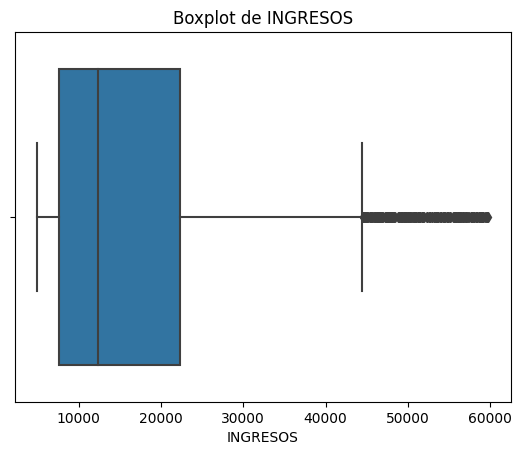

In [202]:
rev_outliers(df,'INGRESOS')

Deciles de SALDO_TOTAL_SF:
0.10           0.00
0.20           0.00
0.30           0.00
0.40           0.00
0.50           0.00
0.60      36,718.20
0.70     406,621.40
0.80   1,237,404.00
0.90   3,883,832.50
0.95   8,258,946.45
Name: SALDO_TOTAL_SF, dtype: float64

Límite superior: 1791241.25 y Límite inferior: -1074744.75

Valor máximo: 214604475.0

Cantidad de outliers: 663 de 3968. Es un 17.0%.


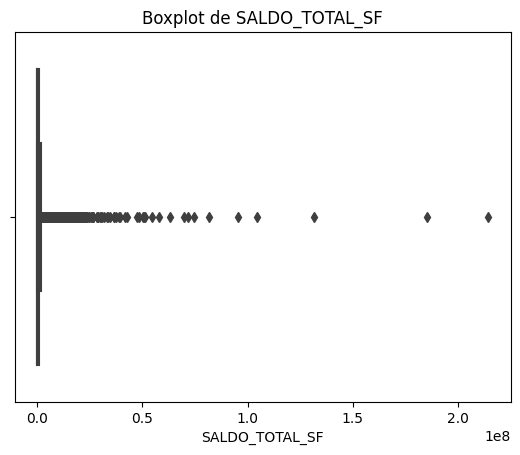

In [203]:
rev_outliers(df,'SALDO_TOTAL_SF')

In [204]:
campo = 'SALDO_TOTAL_SF'
df[df[campo]>1e8].NRODOCUMENTO.count()

4

In [205]:
# Establecer el límite máximo
df.loc[df[campo] > 1e8, campo] = 1e8

Deciles de SHARE_OF_WALLET:
0.10   0.00
0.20   0.00
0.30   0.00
0.40   0.00
0.50   0.00
0.60   0.00
0.70   0.00
0.80   0.00
0.90   0.04
0.95   0.15
Name: SHARE_OF_WALLET, dtype: float64

Límite superior: 0.0 y Límite inferior: 0.0

Valor máximo: 1.0

Cantidad de outliers: 560 de 3968. Es un 14.000000000000002%.


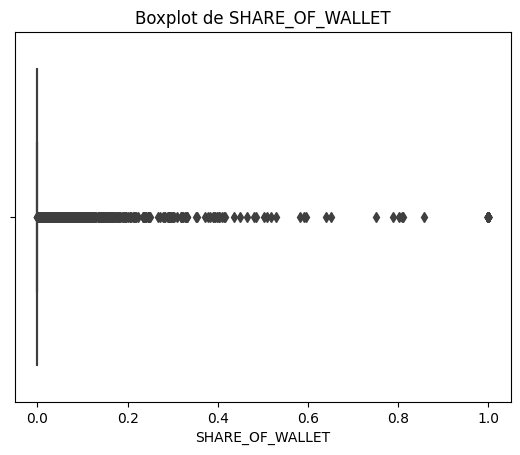

In [206]:
rev_outliers(df,'SHARE_OF_WALLET')

Deciles de CANT_ENTIDADES_CON_DEUDA_SF:
0.10   0.00
0.20   0.00
0.30   0.00
0.40   0.00
0.50   0.00
0.60   1.00
0.70   2.00
0.80   3.00
0.90   4.00
0.95   5.00
Name: CANT_ENTIDADES_CON_DEUDA_SF, dtype: float64

Límite superior: 5.0 y Límite inferior: -3.0

Valor máximo: 10.0

Cantidad de outliers: 145 de 3968. Es un 4.0%.


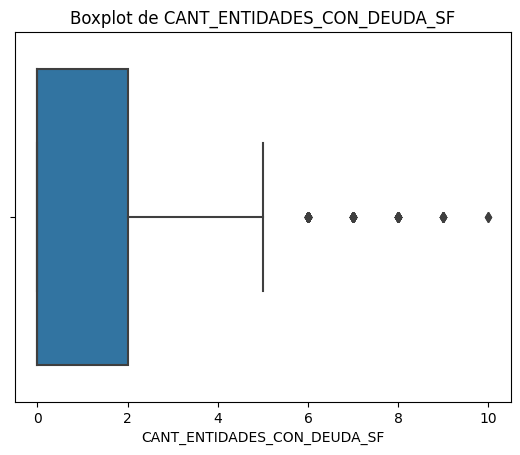

In [207]:
rev_outliers(df,'CANT_ENTIDADES_CON_DEUDA_SF')

Deciles de CANT_CRED_VIGENTES_SF:
0.10    0.00
0.20    0.00
0.30    0.00
0.40    0.00
0.50    0.00
0.60    1.00
0.70    3.00
0.80    7.00
0.90   16.00
0.95   26.00
Name: CANT_CRED_VIGENTES_SF, dtype: float64

Límite superior: 12.5 y Límite inferior: -7.5

Valor máximo: 722.0

Cantidad de outliers: 507 de 3968. Es un 13.0%.


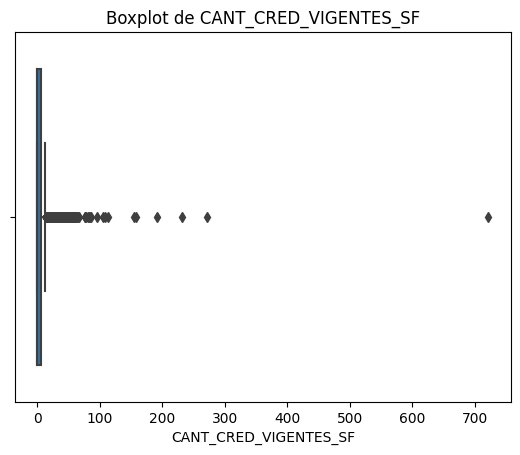

In [208]:
rev_outliers(df,'CANT_CRED_VIGENTES_SF')

In [209]:
campo = 'CANT_CRED_VIGENTES_SF'
df[df[campo]>150].NRODOCUMENTO.count()

6

In [210]:
# Establecer el límite máximo
df.loc[df[campo] > 150, campo] = 150

Deciles de CANT_DESEMB_AVV_6M:
0.10   0.00
0.20   0.00
0.30   0.00
0.40   0.00
0.50   0.00
0.60   0.00
0.70   0.00
0.80   0.00
0.90   1.00
0.95   3.00
Name: CANT_DESEMB_AVV_6M, dtype: float64

Límite superior: 0.0 y Límite inferior: 0.0

Valor máximo: 1617.0

Cantidad de outliers: 550 de 3968. Es un 14.000000000000002%.


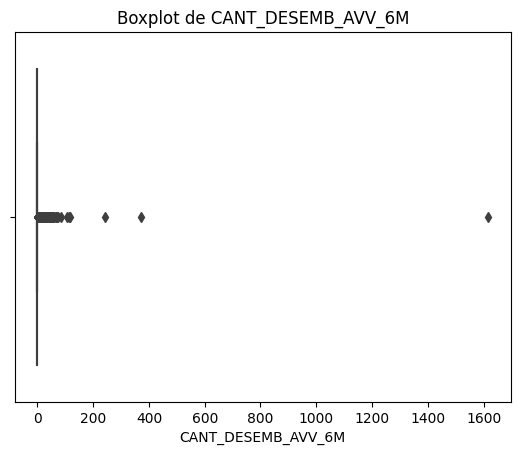

In [211]:
rev_outliers(df,'CANT_DESEMB_AVV_6M')

In [212]:
campo = 'CANT_DESEMB_AVV_6M'
df[df[campo]>40].NRODOCUMENTO.count()

28

In [213]:
# Establecer el límite máximo
df.loc[df[campo] > 40, campo] = 40

Deciles de CANT_PASIVOS_AVV_ULT6M:
0.10   1.00
0.20   1.00
0.30   1.00
0.40   1.00
0.50   1.00
0.60   1.00
0.70   1.00
0.80   2.00
0.90   2.00
0.95   2.00
Name: CANT_PASIVOS_AVV_ULT6M, dtype: float64

Límite superior: 3.5 y Límite inferior: -0.5

Valor máximo: 4.0

Cantidad de outliers: 4 de 3968. Es un 0.0%.


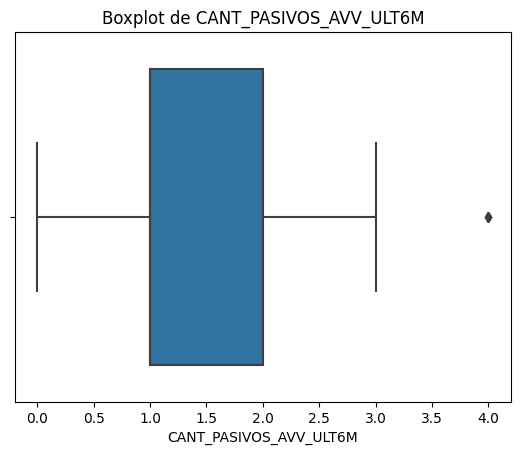

In [214]:
rev_outliers(df,'CANT_PASIVOS_AVV_ULT6M')

Deciles de SALDO_PROM_PASIVOS_AVV_6M:
0.10             0.00
0.20             0.99
0.30           904.77
0.40        77,829.04
0.50       966,176.29
0.60     6,340,766.92
0.70    21,557,672.86
0.80    63,479,170.27
0.90   184,677,731.28
0.95   458,113,071.16
Name: SALDO_PROM_PASIVOS_AVV_6M, dtype: float64

Límite superior: 90916584.64 y Límite inferior: -54549947.24

Valor máximo: 82102471200.0

Cantidad de outliers: 658 de 3968. Es un 17.0%.


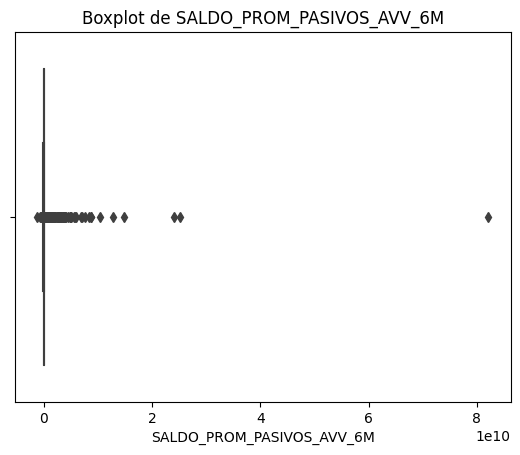

In [215]:
rev_outliers(df,'SALDO_PROM_PASIVOS_AVV_6M')

In [216]:
campo = 'SALDO_PROM_PASIVOS_AVV_6M'
df[df[campo]>1e10].NRODOCUMENTO.count()

6

In [217]:
# Establecer el límite máximo
df.loc[df[campo] > 0.4e10, campo] = 0.4e10

In [218]:
df[df[campo]<-0.3e9].NRODOCUMENTO.count()

5

In [219]:
# Establecer el límite mínimo
df.loc[df[campo] < -0.3e9, campo] = -0.3e9

Deciles de SALDO_PROM_PASIVOS_AVV_6M:
0.10             0.00
0.20             0.99
0.30           904.77
0.40        77,829.04
0.50       966,176.29
0.60     6,340,766.92
0.70    21,557,672.86
0.80    63,479,170.27
0.90   184,677,731.28
0.95   458,113,071.16
Name: SALDO_PROM_PASIVOS_AVV_6M, dtype: float64

Límite superior: 90916584.64 y Límite inferior: -54549947.24

Valor máximo: 4000000000.0

Cantidad de outliers: 658 de 3968. Es un 17.0%.


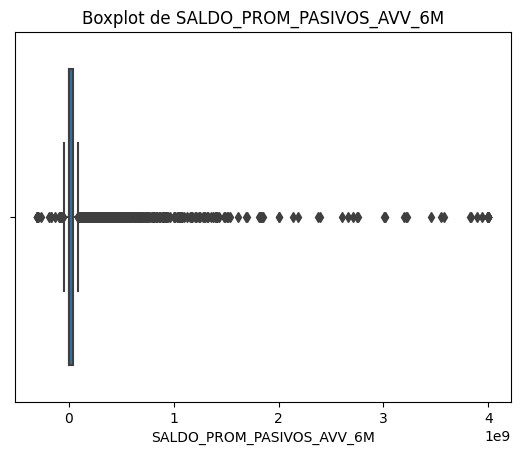

In [220]:
rev_outliers(df,'SALDO_PROM_PASIVOS_AVV_6M')

Deciles de CANT_ACTIVOS_AVV_ULT6M:
0.10   0.00
0.20   0.00
0.30   0.00
0.40   0.00
0.50   0.00
0.60   0.00
0.70   0.00
0.80   1.00
0.90   1.00
0.95   2.00
Name: CANT_ACTIVOS_AVV_ULT6M, dtype: float64

Límite superior: 2.5 y Límite inferior: -1.5

Valor máximo: 4.0

Cantidad de outliers: 43 de 3968. Es un 1.0%.


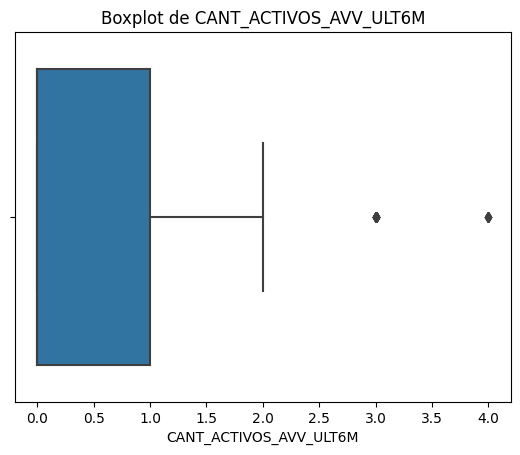

In [221]:
rev_outliers(df,'CANT_ACTIVOS_AVV_ULT6M')

Deciles de SALDO_PROM_ACTIVOS_AVV_6M:
0.10             0.00
0.20             0.00
0.30             0.00
0.40             0.00
0.50             0.00
0.60             0.00
0.70             0.00
0.80    73,428,824.65
0.90   268,734,119.32
0.95   479,263,316.72
Name: SALDO_PROM_ACTIVOS_AVV_6M, dtype: float64

Límite superior: 30023949.21 y Límite inferior: -18014369.53

Valor máximo: 97207732885.71169

Cantidad de outliers: 925 de 3968. Es un 23.0%.


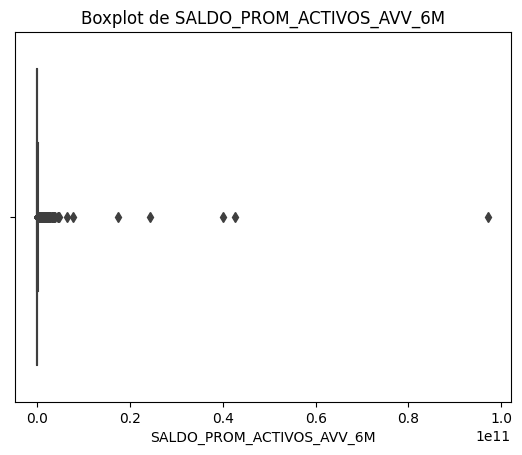

In [222]:
rev_outliers(df,'SALDO_PROM_ACTIVOS_AVV_6M')

In [223]:
campo = 'SALDO_PROM_ACTIVOS_AVV_6M'
df[df[campo]>0.05e11].NRODOCUMENTO.count()

7

In [224]:
# Establecer el límite máximo
df.loc[df[campo] > 2e9, campo] = 2e9

Deciles de SALDO_PROM_ACTIVOS_AVV_6M:
0.10             0.00
0.20             0.00
0.30             0.00
0.40             0.00
0.50             0.00
0.60             0.00
0.70             0.00
0.80    73,428,824.65
0.90   268,734,119.32
0.95   479,263,316.72
Name: SALDO_PROM_ACTIVOS_AVV_6M, dtype: float64

Límite superior: 30023949.21 y Límite inferior: -18014369.53

Valor máximo: 2000000000.0

Cantidad de outliers: 925 de 3968. Es un 23.0%.


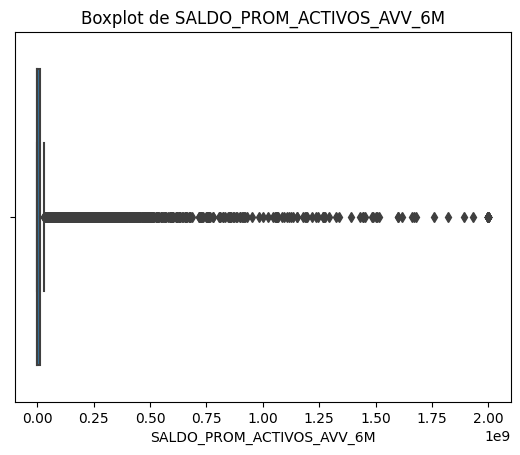

In [225]:
rev_outliers(df,'SALDO_PROM_ACTIVOS_AVV_6M')

Deciles de CANT_CONVENIOS_ULT6M:
0.10   0.00
0.20   0.00
0.30   0.00
0.40   0.00
0.50   0.00
0.60   0.00
0.70   0.00
0.80   1.00
0.90   2.00
0.95   3.00
Name: CANT_CONVENIOS_ULT6M, dtype: float64

Límite superior: 2.5 y Límite inferior: -1.5

Valor máximo: 4.0

Cantidad de outliers: 230 de 3968. Es un 6.0%.


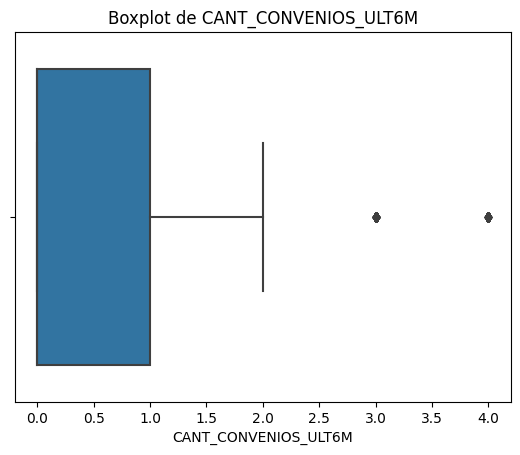

In [226]:
rev_outliers(df,'CANT_CONVENIOS_ULT6M')

Deciles de PASIVOS_TOTALES:
0.10        0.00
0.20      299.40
0.30    1,478.10
0.40    2,437.00
0.50    3,711.00
0.60    5,388.20
0.70    7,640.70
0.80   11,857.60
0.90   20,436.60
0.95   32,679.90
Name: PASIVOS_TOTALES, dtype: float64

Límite superior: 22436.12 y Límite inferior: -11900.88

Valor máximo: 3435753.0

Cantidad de outliers: 350 de 3968. Es un 9.0%.


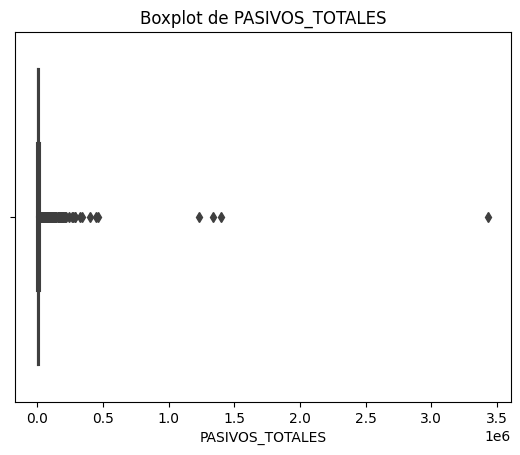

In [227]:
rev_outliers(df,'PASIVOS_TOTALES')

Deciles de LEA_APROBADO_AVV_ULT6M:
0.10               0.00
0.20               0.00
0.30               0.00
0.40               0.00
0.50               0.00
0.60               0.00
0.70     200,000,000.00
0.80     400,000,000.00
0.90     799,999,730.00
0.95   1,000,000,000.00
Name: LEA_APROBADO_AVV_ULT6M, dtype: float64

Límite superior: 750000000.0 y Límite inferior: -450000000.0

Valor máximo: 1300000000000.0

Cantidad de outliers: 402 de 3968. Es un 10.0%.


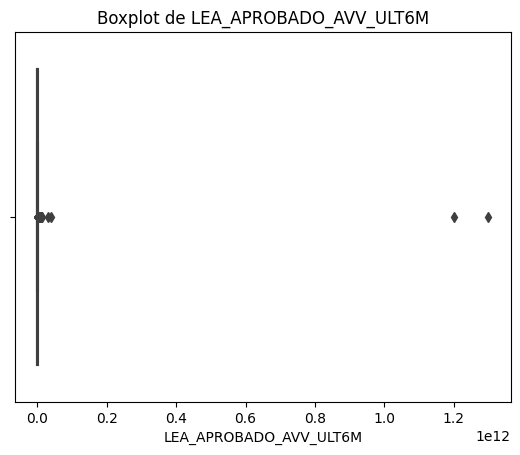

In [228]:
rev_outliers(df,'LEA_APROBADO_AVV_ULT6M')

In [229]:
campo = 'LEA_APROBADO_AVV_ULT6M'
df[df[campo]>2e9].NRODOCUMENTO.count()

65

In [230]:
# Establecer el límite máximo
df.loc[df[campo] > 2e9, campo] = 2e9

In [231]:
campo = 'PASIVOS_TOTALES'
df[df[campo]>0.2e6].NRODOCUMENTO.count()

18

In [232]:
# Establecer el límite máximo
df.loc[df[campo] > 0.2e6, campo] = 0.2e6

## MODELO

In [233]:
df.columns

Index(['NRODOCUMENTO', 'INGRESOS', 'SALDO_TOTAL_SF', 'SALDO_TOTAL_AVV_SF',
       'SHARE_OF_WALLET', 'CANT_ENTIDADES_CON_DEUDA_SF',
       'CANT_CRED_VIGENTES_SF', 'CANT_DESEMB_AVV_6M', 'PROM_DESEM_AVV_6M',
       'SALDO_PROM_PASIVOS_AVV_6M', 'SALDO_PROM_ACTIVOS_AVV_6M',
       'LEA_APROBADO_AVV_ULT6M', 'CANT_ACTIVOS_AVV_ULT6M',
       'CANT_CONVENIOS_ULT6M', 'CANT_PASIVOS_AVV_ULT6M', 'PASIVOS_TOTALES'],
      dtype='object')

In [234]:
df = df[['NRODOCUMENTO',
          #'INGRESOS', 
          #'SALDO_TOTAL_SF',
          #'SALDO_TOTAL_AVV_SF',
          'SHARE_OF_WALLET', 
          #'CANT_ENTIDADES_CON_DEUDA_SF',
          'CANT_CRED_VIGENTES_SF', 
          #'CANT_DESEMB_AVV_6M', 
         # 'PROM_DESEM_AVV_6M',
          'SALDO_PROM_PASIVOS_AVV_6M', 
          #'SALDO_PROM_ACTIVOS_AVV_6M',
          #'LEA_APROBADO_AVV_ULT6M', 
          'CANT_ACTIVOS_AVV_ULT6M',
          #'CANT_CONVENIOS_ULT6M', 
          'CANT_PASIVOS_AVV_ULT6M', 
          #'PASIVOS_TOTALES'
         ]]

In [235]:
cols_a_escalar = df.columns.tolist()
del cols_a_escalar[0]
cols_a_escalar


['SHARE_OF_WALLET',
 'CANT_CRED_VIGENTES_SF',
 'SALDO_PROM_PASIVOS_AVV_6M',
 'CANT_ACTIVOS_AVV_ULT6M',
 'CANT_PASIVOS_AVV_ULT6M']

In [236]:
cols_a_escalar2 = cols_a_escalar.copy()
del cols_a_escalar2[2]

In [237]:
# Escalamos las variables de 0 a 1
df_modelo = df[cols_a_escalar]

# Escalamos las variables a un rango de 0 a 1, para aplicar el modelo de Kmeans
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df_modelo)   
X = scaler.transform(df_modelo[cols_a_escalar])
X.shape

(3968, 5)

In [238]:
# Verificamos el cambio realizado
print('X_max:', X.max(axis=0))
print('X_min:', X.min(axis=0))

X_max: [1. 1. 1. 1. 1.]
X_min: [0. 0. 0. 0. 0.]


In [239]:
# Creamos dataframe con valores escalads
X = pd.DataFrame(X, columns=cols_a_escalar)
#X = X.merge(df_modelo[['SHARE_OF_WALLET']], left_index=True, right_index=True)
X.head()

,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M
0,0.00,0.00,0.08,0.00,0.50
1,0.00,0.00,0.07,0.00,0.25
2,0.00,0.00,0.14,0.00,0.25
3,0.00,0.00,0.07,0.00,0.25
4,0.00,0.02,0.07,0.00,0.50


In [240]:
# Seteamos los parámetros para ejecutar K-means
"""Parámetros a ingresar en el modelo K-Means"""
kmeans_kwargs = {
    #init: controla la técnica de inicialización, la técnica k-means++ permite acelerar el proceso de convergencia
    "init": "k-means++",
    #n_init: Número de inicializaciones a ejecutar. 2 ejecuciones de un mismo cluster pueden converger a diferente selecciones de clusters (centroides).
    # el programa correrá el número indicado y elegirá aquel con el menor WCSS 
    "n_init": 20,
    #max_iter: número de iteraciones máximas para cada inicialización del modelo k-means
    "max_iter": 100,
    #random_state: mantener un mismo random_state para asegurar la replicabilidad del modelo
    "random_state": 0,
    #algorithm: Se elige usar el algoritmo Elkan para el modelo K means 
    "algorithm": "elkan"
}

In [241]:
#Lista a visualizar posteriormente
inertias = []
db_coefs = []
#Itentaremos desde 2 hasta 20 clusters
for i in range(2,21):
    
    #Ejecutamos el modelo de Kmeans para cada número de clusters (range(2,21))
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs).fit(X)
    """Método del codo"""
    #Guardamos las Inertias (WCSS)
    inertias.append(kmeans.inertia_)
    """Davies bouldin"""
    db_score = davies_bouldin_score(X, kmeans.labels_)
    db_coefs.append(db_score)

In [242]:
#Ejecutamos el análisis PCA
pca = PCA(n_components= X.shape[1]) # número de componentes = número de columnas

principal_components = pd.DataFrame(pca.fit_transform(X), columns= X.columns)
#Varianza explicada
variance = pca.explained_variance_ratio_
#Suma acumulada de la varianza explicada para poder graficar
explained_variance = np.cumsum(np.round(variance, decimals=3)*100)

(0.0, 1.0)

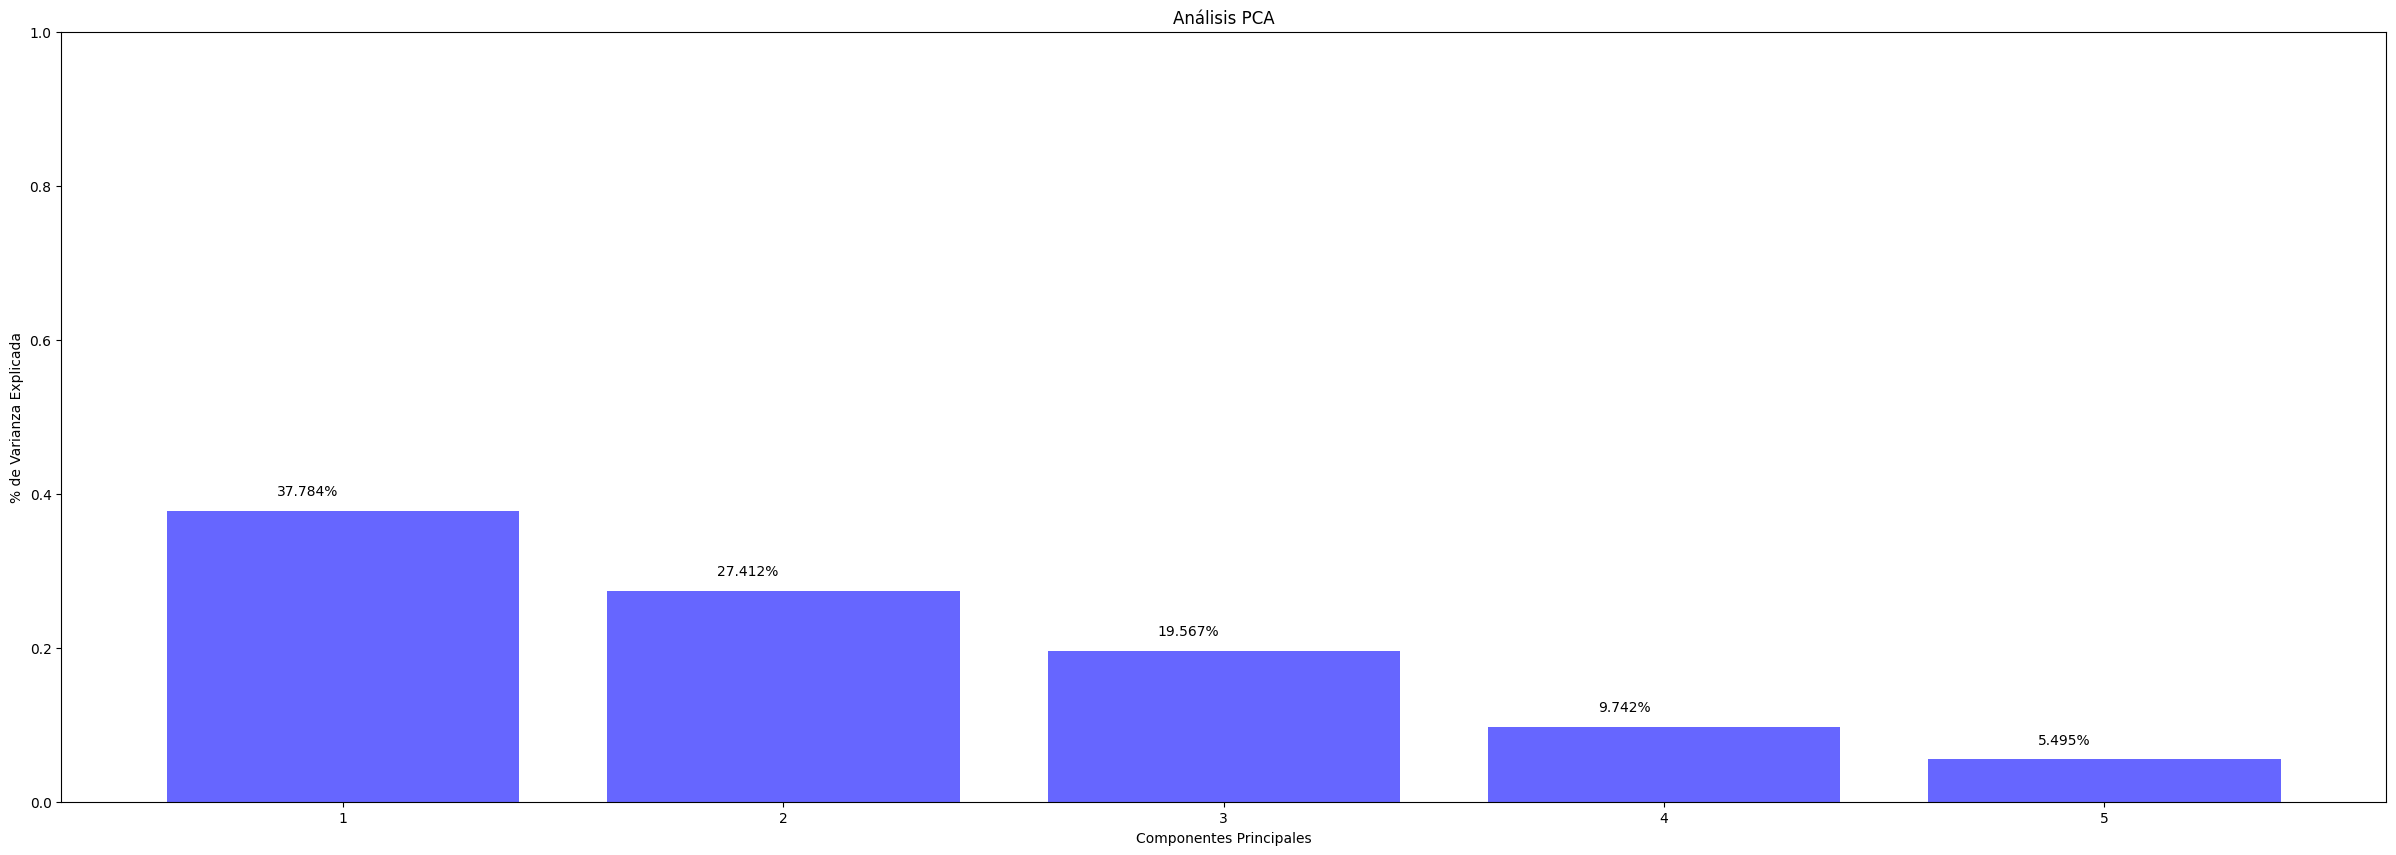

In [243]:
# Graficamos el resultado de PCA
n_var = X.shape[1] + 1
plt.figure(figsize= (30,10))
plt.ylabel('% de Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.title('Análisis PCA')
plt.bar(range(1,n_var),variance, alpha=0.6, color= 'blue')
for a,b in zip(list(range(1,n_var)), variance): 
    plt.text(a-0.15,b+0.02, str((b*100).round(3)) + "%")

plt.ylim(0,1)

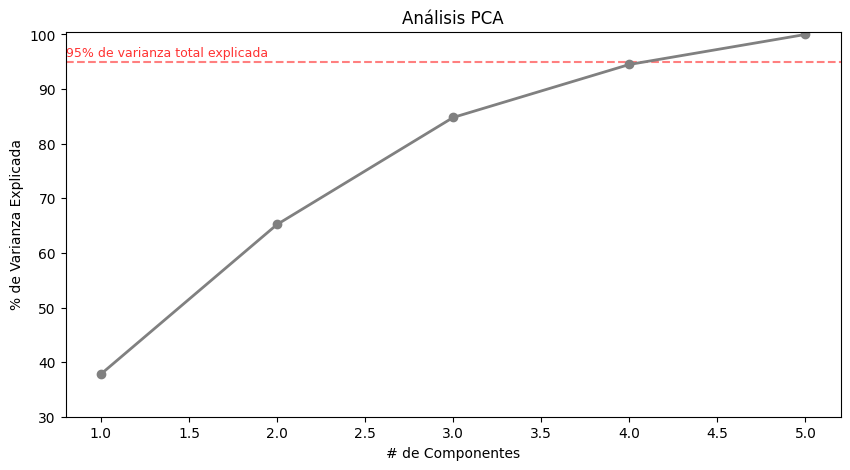

[ 37.8  65.2  84.8  94.5 100. ]


In [244]:
# Graficamos el porcentaje de varianza explicada
plt.figure(figsize=(10,5))
plt.ylabel('% de Varianza Explicada')
plt.xlabel('# de Componentes')
plt.title('Análisis PCA')
plt.ylim(30,100.5)
plt.axhline(95, ls= '--', color = 'red', alpha = 0.5)
plt.text(0.8, 96, '95% de varianza total explicada', color = 'red', fontsize=9, alpha = 0.8)
plt.plot(range(1,n_var), explained_variance, marker='o', lw=2, color='grey')
plt.show()
print(explained_variance)

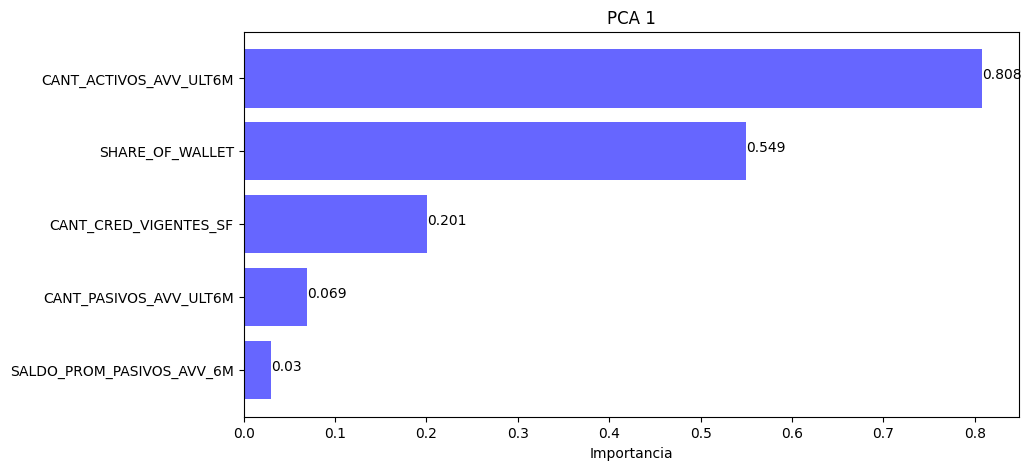

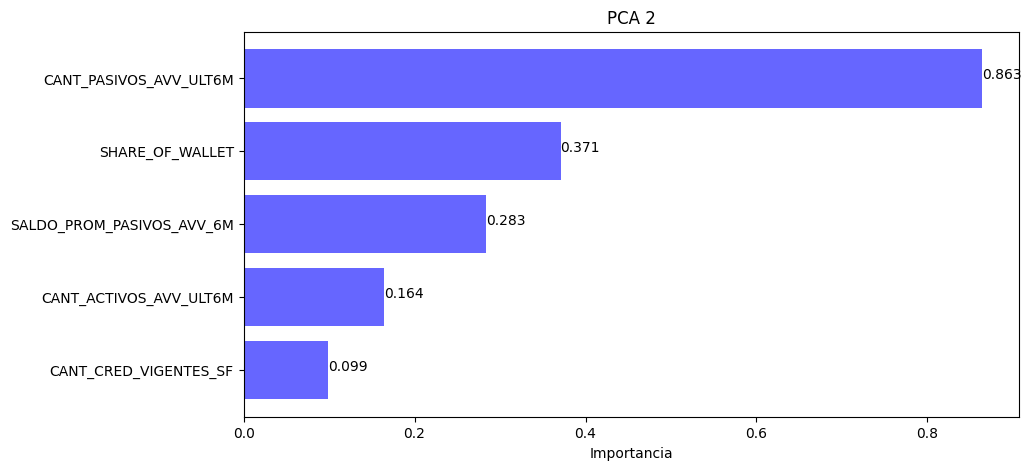

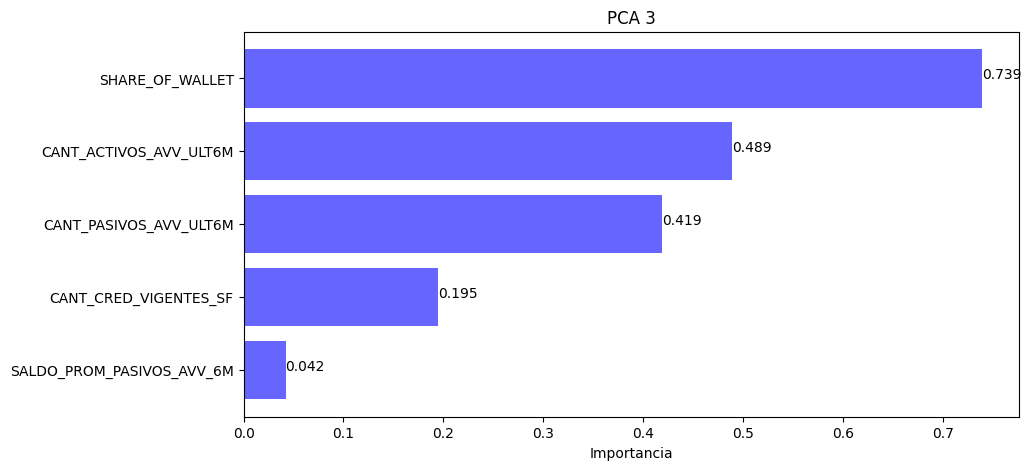

In [245]:
# La importancia de cada característica se refleja en la magnitud de los valores correspondientes en los vectores propios (a mayor magnitud, mayor importancia).
# Se muestra la grafica para las 3 componentes principales
importance_abs = abs(pca.components_)
for i_pca in range(importance_abs.shape[0]):
    n_importance = np.argsort(importance_abs[i_pca,:])
    importance_abs_ord = importance_abs[i_pca,:][n_importance]
    if i_pca<3:
        n_var = X.shape[1] + 1
        plt.figure(figsize= (10,5))
        plt.xlabel('Importancia')
        plt.title(f'PCA {i_pca+1}')
        plt.barh(range(1,n_var), importance_abs_ord, alpha=0.6, color= 'blue')
        plt.yticks(range(1,n_var), df_modelo.columns[n_importance])
        for a,b in zip(list(range(1,n_var)), importance_abs_ord): 
            plt.text(b, a, str((b).round(3)))

In [246]:
# Funcion para crear tabla de importancia para PCA
def pca_table_importance(importance_abs, var_names, order_by='PCA_1'):
    index_pca = [f'PCA_{i+1}' for i in range(importance_abs.shape[0])]
    return pd.DataFrame(importance_abs, columns=var_names, index=index_pca).T.sort_values(by=order_by, ascending=False)

In [247]:
# Creamos tabla donde se resume la importancia para el analisis de PCA, rdenadas por la primera componente 
df_pca_table = pca_table_importance(importance_abs, df_modelo.columns, order_by='PCA_1')
df_pca_table

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
CANT_ACTIVOS_AVV_ULT6M,0.81,0.16,0.49,0.03,0.29
SHARE_OF_WALLET,0.55,0.37,0.74,0.10,0.07
CANT_CRED_VIGENTES_SF,0.20,0.10,0.20,0.07,0.95
CANT_PASIVOS_AVV_ULT6M,0.07,0.86,0.42,0.27,0.00
SALDO_PROM_PASIVOS_AVV_6M,0.03,0.28,0.04,0.95,0.08


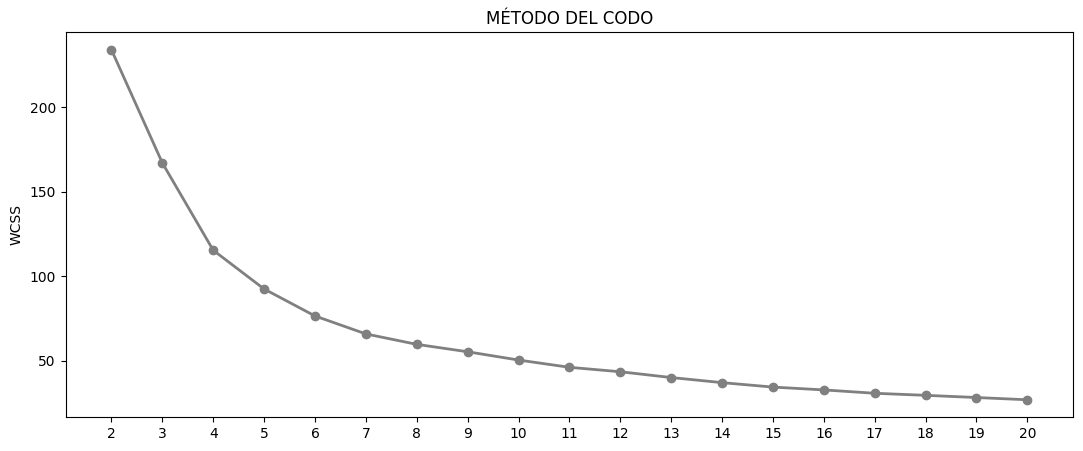

In [248]:
"""Gráfico del método del codo"""
plt.figure(figsize=(13,5)) #Tamaño de la figura
plt.title('MÉTODO DEL CODO') #Título
plt.ylabel('WCSS') #Título del eje Y
plt.xticks(range(2,21)) #Valores del eje X
#Ejecutar gráfico
plt.plot(range(2,21) ,inertias, marker='o', lw=2, color='grey')
plt.show()

## K MEANS

In [249]:
# Probamos con un K
n_clusters = 4

km = KMeans(n_clusters= n_clusters, **kmeans_kwargs)
km.fit(X)
clusters = km.labels_
centroids = km.cluster_centers_

In [250]:
# En esta gráfica podemos ver una representación compacta de los clusters seleccionados con kmeans.
print(f'Mediante el Análisis de 2 componentes principales que explican: {explained_variance[1]}% de la varianza')

Mediante el Análisis de 2 componentes principales que explican: 65.2% de la varianza


In [251]:
# En esta gráfica podemos ver una representación compacta de los clusters seleccionados con kmeans.
print(f'Mediante el Análisis de 3 componentes principales que explican: {explained_variance[2]}% de la varianza')

Mediante el Análisis de 3 componentes principales que explican: 84.80000000000001% de la varianza


## SILUETA

K = 4 Average silhouette_score: 0.6124953425170852


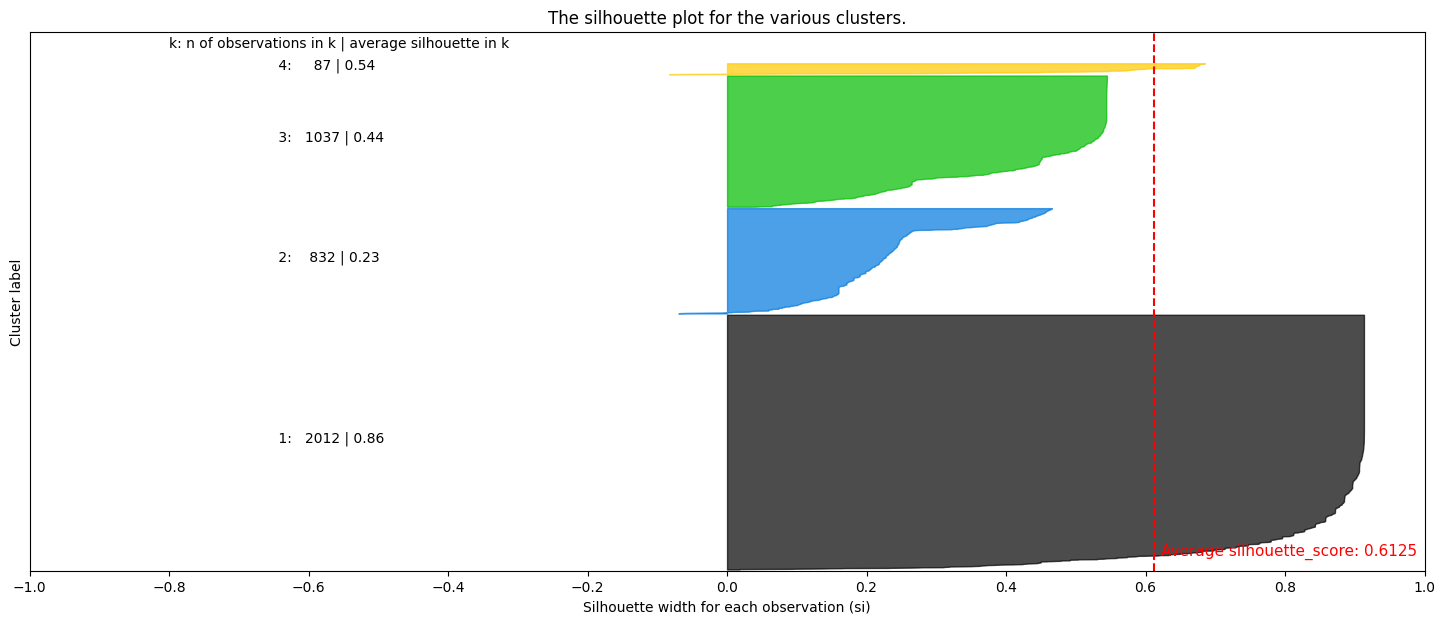

In [252]:
# Grafico para la silueta promedio
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-1, 1])
ax1.set_ylim([0, len(X)*1.06 + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters= n_clusters, **kmeans_kwargs)
cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print("K =", n_clusters, "Average silhouette_score:", silhouette_avg)

sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.8, y_lower + 0.5 * size_cluster_i, f'{i+1:26d}: {size_cluster_i:6d} | {ith_cluster_silhouette_values.sum()/size_cluster_i:4.2f}')
    y_lower = y_upper + 10

ax1.text(-0.8, len(X)*1.03 + (n_clusters + 1) * 10, 'k: n of observations in k | average silhouette in k')
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("Silhouette width for each observation (si)")
ax1.set_ylabel("Cluster label")
ax1.text(silhouette_avg+0.01, len(X)*0.03, f'Average silhouette_score: {silhouette_avg:.4f}', color = 'red', fontsize=11)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [253]:
df_modelo.shape

(3968, 5)

In [254]:
df_modelo.shape[0] *0.3

1190.3999999999999

In [255]:
df_modelo.shape[0] *0.35

1388.8

In [256]:
df_modelo.shape[0] *0.5

1984.0

In [257]:
# Agregamos la columna CLUSTER al dataframe para el analisis
df['CLUSTER'] = cluster_labels + 1
df.head()

,NRODOCUMENTO,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M,CLUSTER
0,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,0.00,0.00,"47,079,464.84",0.00,2.00,3
1,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,0.00,0.00,"11,592,875.57",0.00,1.00,1
2,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,0.00,0.00,"314,088,277.62",0.00,1.00,1
3,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,0.00,0.00,183.99,0.00,1.00,1
4,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,0.00,3.00,"-1,399,863.19",0.00,2.00,3


In [258]:
# Agregamos la columna CLUSTER al dataframe para el analisis
df_modelo['CLUSTER'] = cluster_labels + 1
df_modelo.head()

C:\Users\VY656TW\AppData\Local\Temp\ipykernel_10124\1788835090.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M,CLUSTER
0,0.00,0.00,"47,079,464.84",0.00,2.00,3
1,0.00,0.00,"11,592,875.57",0.00,1.00,1
2,0.00,0.00,"314,088,277.62",0.00,1.00,1
3,0.00,0.00,183.99,0.00,1.00,1
4,0.00,3.00,"-1,399,863.19",0.00,2.00,3


In [259]:
df_modelo.shape

(3968, 6)

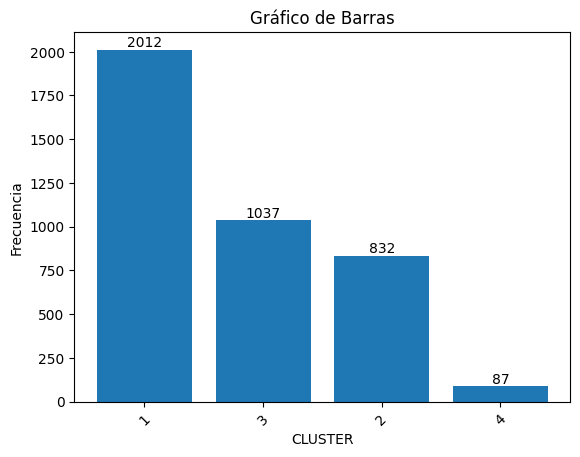

In [260]:
# Contar los valores únicos del campo categórico
counts = df_modelo['CLUSTER'].value_counts()

# Crear el gráfico de barras
plt.bar(np.arange(len(counts)), counts.values)

# Etiquetar los valores
for i, value in enumerate(counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Añadir título y etiquetas de los ejes
plt.title('Gráfico de Barras')
plt.xlabel('CLUSTER')
plt.ylabel('Frecuencia')

# Establecer las etiquetas del eje x
plt.xticks(np.arange(len(counts)), counts.index)

# Rotar las etiquetas del eje x si es necesario
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

In [261]:
df_modelo.shape

(3968, 6)

## RESULTADOS

In [262]:
# Calculamos los estadísticos por cluster y variable
lista_descriptivos = []
for cluster in  df_modelo.CLUSTER.unique():
    df_tmp = df_modelo[df_modelo.CLUSTER == cluster]
    medianas = df_tmp.median()
    df_describe = df_tmp.describe()
    
    # Crear un DataFrame para las medianas y luego concatenar
    df_medianas = pd.DataFrame(medianas).transpose()
    df_medianas.index = ['medianas']
    df_describe = pd.concat([df_describe, df_medianas])
    
    df_describe.index = '{}_'.format(cluster) + df_describe.index.astype(str)
    lista_descriptivos.append(df_describe)
    print(cluster)
    display(df_describe)
df_describe_final = pd.concat(lista_descriptivos)

3


,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M,CLUSTER
3_count,"1,037.00","1,037.00","1,037.00","1,037.00","1,037.00","1,037.00"
3_mean,0.01,2.55,"225,372,187.56",0.17,2.11,3.00
3_std,0.04,5.91,"638,286,433.85",0.38,0.32,0.00
3_min,0.00,0.00,"-300,000,000.00",0.00,2.00,3.00
3_25%,0.00,0.00,"53,043.94",0.00,2.00,3.00
3_50%,0.00,0.00,"15,240,993.35",0.00,2.00,3.00
3_75%,0.00,2.00,"132,444,887.38",0.00,2.00,3.00
3_max,0.41,54.00,"4,000,000,000.00",2.00,4.00,3.00
3_medianas,0.00,0.00,"15,240,993.35",0.00,2.00,3.00


1


,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M,CLUSTER
1_count,"2,012.00","2,012.00","2,012.00","2,012.00","2,012.00","2,012.00"
1_mean,0.00,2.12,"49,988,762.36",0.00,0.99,1.00
1_std,0.02,5.89,"246,533,197.87",0.00,0.11,0.00
1_min,0.00,0.00,"-291,054,174.58",0.00,0.00,1.00
1_25%,0.00,0.00,1.68,0.00,1.00,1.00
1_50%,0.00,0.00,"119,397.08",0.00,1.00,1.00
1_75%,0.00,1.00,"13,252,626.09",0.00,1.00,1.00
1_max,0.52,82.00,"4,000,000,000.00",0.00,1.00,1.00
1_medianas,0.00,0.00,"119,397.08",0.00,1.00,1.00


2


,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M,CLUSTER
2_count,832.00,832.00,832.00,832.00,832.00,832.00
2_mean,0.05,15.61,"44,915,674.07",1.33,0.98,2.00
2_std,0.09,19.42,"215,356,980.00",0.59,0.44,0.00
2_min,0.00,0.00,"-300,000,000.00",0.00,0.00,2.00
2_25%,0.00,3.00,0.42,1.00,1.00,2.00
2_50%,0.00,9.00,"971,813.95",1.00,1.00,2.00
2_75%,0.06,20.00,"22,862,023.35",2.00,1.00,2.00
2_max,0.50,150.00,"4,000,000,000.00",4.00,3.00,2.00
2_medianas,0.00,9.00,"971,813.95",1.00,1.00,2.00


4


,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M,CLUSTER
4_count,87.00,87.00,87.00,87.00,87.00,87.00
4_mean,0.95,3.90,"440,120,327.84",1.05,1.59,4.00
4_std,0.13,16.22,"843,427,578.78",0.75,0.69,0.00
4_min,0.48,1.00,"-6,519,739.03",0.00,0.00,4.00
4_25%,1.00,1.00,"12,568,123.79",1.00,1.00,4.00
4_50%,1.00,1.00,"150,710,670.17",1.00,2.00,4.00
4_75%,1.00,2.00,"368,169,843.87",1.00,2.00,4.00
4_max,1.00,150.00,"4,000,000,000.00",3.00,3.00,4.00
4_medianas,1.00,1.00,"150,710,670.17",1.00,2.00,4.00


In [263]:
# Listamos las columnas a plotear
cols_plot = cols_a_escalar

In [264]:
# Ordenamos la data por CLUSTER
df_modelo.sort_values('CLUSTER', ascending=True, inplace = True)

C:\Users\VY656TW\AppData\Local\Temp\ipykernel_10124\3681736339.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [265]:
# Ploteamos Boxplots por cada variable y cluster
for i in range(len(cols_plot)):
  
        
        # Visualizamos el par de variables
      
        print('cantidad de 0s')
        print(len(df_modelo[df_modelo[cols_plot[i]]==0]))
        print(len(df_modelo[df_modelo[cols_plot[i]]==0])/df_modelo.shape[0] )
        
        
        fig = px.box(df_modelo, y =cols_plot[i], color='CLUSTER')
        fig.show()
#         pio.write_image(fig, 'escenario4_k6_scatter_plot_{}_{}.png'.format(cols_plot[i], cols_plot[j]))

cantidad de 0s
3408
0.8588709677419355


cantidad de 0s
2186
0.5509072580645161


cantidad de 0s
341
0.0859375


cantidad de 0s
2894
0.7293346774193549


cantidad de 0s
114
0.028729838709677418


**EXPORTAR DATA**

In [266]:
df_modelo.head()

,SHARE_OF_WALLET,CANT_CRED_VIGENTES_SF,SALDO_PROM_PASIVOS_AVV_6M,CANT_ACTIVOS_AVV_ULT6M,CANT_PASIVOS_AVV_ULT6M,CLUSTER
1535,0.00,0.00,1.52,0.00,1.00,1
1451,0.00,1.00,"18,604,578.23",0.00,1.00,1
1450,0.00,0.00,0.11,0.00,1.00,1
3545,0.00,3.00,"181,702.13",0.00,1.00,1
2551,0.00,0.00,1.34,0.00,1.00,1


In [267]:
df_modelo.shape

(3968, 6)

In [268]:
df_inicial.head()

,NRODOCUMENTO,SEGMENTO_VENTAS,INGRESOS,ESTADO_CRM,SALDO_TOTAL_SF,SALDO_TOTAL_AVV_SF,SHARE_OF_WALLET,CANT_ENTIDADES_CON_DEUDA_SF,CANT_CRED_VIGENTES_SF,CANT_DESEMB_AVV_6M,PROM_DESEM_AVV_6M,SALDO_PROM_PASIVOS_AVV_6M,SALDO_PROM_ACTIVOS_AVV_6M,LEA_APROBADO_AVV_ULT6M,CANT_ACTIVOS_AVV_ULT6M,CANT_CONVENIOS_ULT6M,CANT_PASIVOS_AVV_ULT6M,PASIVOS_TOTALES
0,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,891.01",I,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"47,079,464.84",0.00,0.00,0.00,0.00,2.00,0.00
1,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"9,354.83",A,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"11,592,875.57",0.00,0.00,0.00,1.00,1.00,"4,026.00"
2,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,273.15",A,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"314,088,277.62",0.00,0.00,0.00,3.00,1.00,"5,295.00"
3,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,516.36",I,0.00,0.00,0.00,0.00,0.00,0.00,0.00,183.99,0.00,0.00,0.00,0.00,1.00,"8,616.00"
4,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"8,213.48",A,"644,199.00",0.00,0.00,2.00,3.00,0.00,0.00,"-1,399,863.19",0.00,"500,000,000.00",0.00,3.00,2.00,"2,984.00"


In [269]:
df_inicial.shape

(3968, 18)

In [270]:
# Realizar el join utilizando el índice
df_final = df_inicial.join(df_modelo[['CLUSTER']], on=None)
df_final.head()

,NRODOCUMENTO,SEGMENTO_VENTAS,INGRESOS,ESTADO_CRM,SALDO_TOTAL_SF,SALDO_TOTAL_AVV_SF,SHARE_OF_WALLET,CANT_ENTIDADES_CON_DEUDA_SF,CANT_CRED_VIGENTES_SF,CANT_DESEMB_AVV_6M,PROM_DESEM_AVV_6M,SALDO_PROM_PASIVOS_AVV_6M,SALDO_PROM_ACTIVOS_AVV_6M,LEA_APROBADO_AVV_ULT6M,CANT_ACTIVOS_AVV_ULT6M,CANT_CONVENIOS_ULT6M,CANT_PASIVOS_AVV_ULT6M,PASIVOS_TOTALES,CLUSTER
0,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,891.01",I,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"47,079,464.84",0.00,0.00,0.00,0.00,2.00,0.00,3
1,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"9,354.83",A,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"11,592,875.57",0.00,0.00,0.00,1.00,1.00,"4,026.00",1
2,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,273.15",A,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"314,088,277.62",0.00,0.00,0.00,3.00,1.00,"5,295.00",1
3,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"7,516.36",I,0.00,0.00,0.00,0.00,0.00,0.00,0.00,183.99,0.00,0.00,0.00,0.00,1.00,"8,616.00",1
4,MzY0YzVkNTFiNi1iNzY4LTQ2N2UtODNjOC0zN2E0NDBkM2...,Pyme,"8,213.48",A,"644,199.00",0.00,0.00,2.00,3.00,0.00,0.00,"-1,399,863.19",0.00,"500,000,000.00",0.00,3.00,2.00,"2,984.00",3


# OTROS RESULTADOS

In [271]:
ruta_output = "C:/Users/VY656TW/OneDrive - EY/Shared Documents - Discovery Banca Pyme - AV Villas/General/7. Analytics/02. Clustering/Escenario 15/"

In [272]:
df_final.to_excel(ruta_output+"Resultados_escenario15.xlsx",index=False)

In [273]:
df_final.columns

Index(['NRODOCUMENTO', 'SEGMENTO_VENTAS', 'INGRESOS', 'ESTADO_CRM',
       'SALDO_TOTAL_SF', 'SALDO_TOTAL_AVV_SF', 'SHARE_OF_WALLET',
       'CANT_ENTIDADES_CON_DEUDA_SF', 'CANT_CRED_VIGENTES_SF',
       'CANT_DESEMB_AVV_6M', 'PROM_DESEM_AVV_6M', 'SALDO_PROM_PASIVOS_AVV_6M',
       'SALDO_PROM_ACTIVOS_AVV_6M', 'LEA_APROBADO_AVV_ULT6M',
       'CANT_ACTIVOS_AVV_ULT6M', 'CANT_CONVENIOS_ULT6M',
       'CANT_PASIVOS_AVV_ULT6M', 'PASIVOS_TOTALES', 'CLUSTER'],
      dtype='object')

In [274]:
cols = ['INGRESOS','SALDO_TOTAL_SF', 'SALDO_TOTAL_AVV_SF', 'SHARE_OF_WALLET',
       'CANT_ENTIDADES_CON_DEUDA_SF', 'CANT_CRED_VIGENTES_SF',
       'CANT_DESEMB_AVV_6M', 'PROM_DESEM_AVV_6M', 'SALDO_PROM_PASIVOS_AVV_6M',
       'SALDO_PROM_ACTIVOS_AVV_6M', 'LEA_APROBADO_AVV_ULT6M',
       'CANT_ACTIVOS_AVV_ULT6M', 'CANT_CONVENIOS_ULT6M',
       'CANT_PASIVOS_AVV_ULT6M', 'PASIVOS_TOTALES', 'CLUSTER']

In [275]:
df_final[cols].groupby('CLUSTER').median().reset_index().to_excel(ruta_output+"valores_medianas.xlsx",index=False)

In [276]:
df_final[cols].groupby('CLUSTER').mean().reset_index().to_excel(ruta_output+"valores_medias.xlsx",index=False)

In [277]:
df_final2 = df_final.replace(0, np.nan)

In [278]:
df_final2[cols].groupby('CLUSTER').median().reset_index().to_excel(ruta_output+"valores_mediana_sin0.xlsx",index=False)

In [279]:
df_final2[cols].groupby('CLUSTER').mean().reset_index().to_excel(ruta_output+"valores_medias_sin0.xlsx",index=False)